In [2]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from PJT_Frustration_Induced_Crystallize.main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [46]:
phaseLags = [0.6 * np.pi]
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10 
strengthKs = np.linspace(1, 20, 19)
distanceD0s = np.linspace(0.1, 3, 19)  
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]
models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

In [47]:
lastStateSavePath = r"F:\MS_ExperimentData\lattice"
savePath = (
    f"{lastStateSavePath}/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)

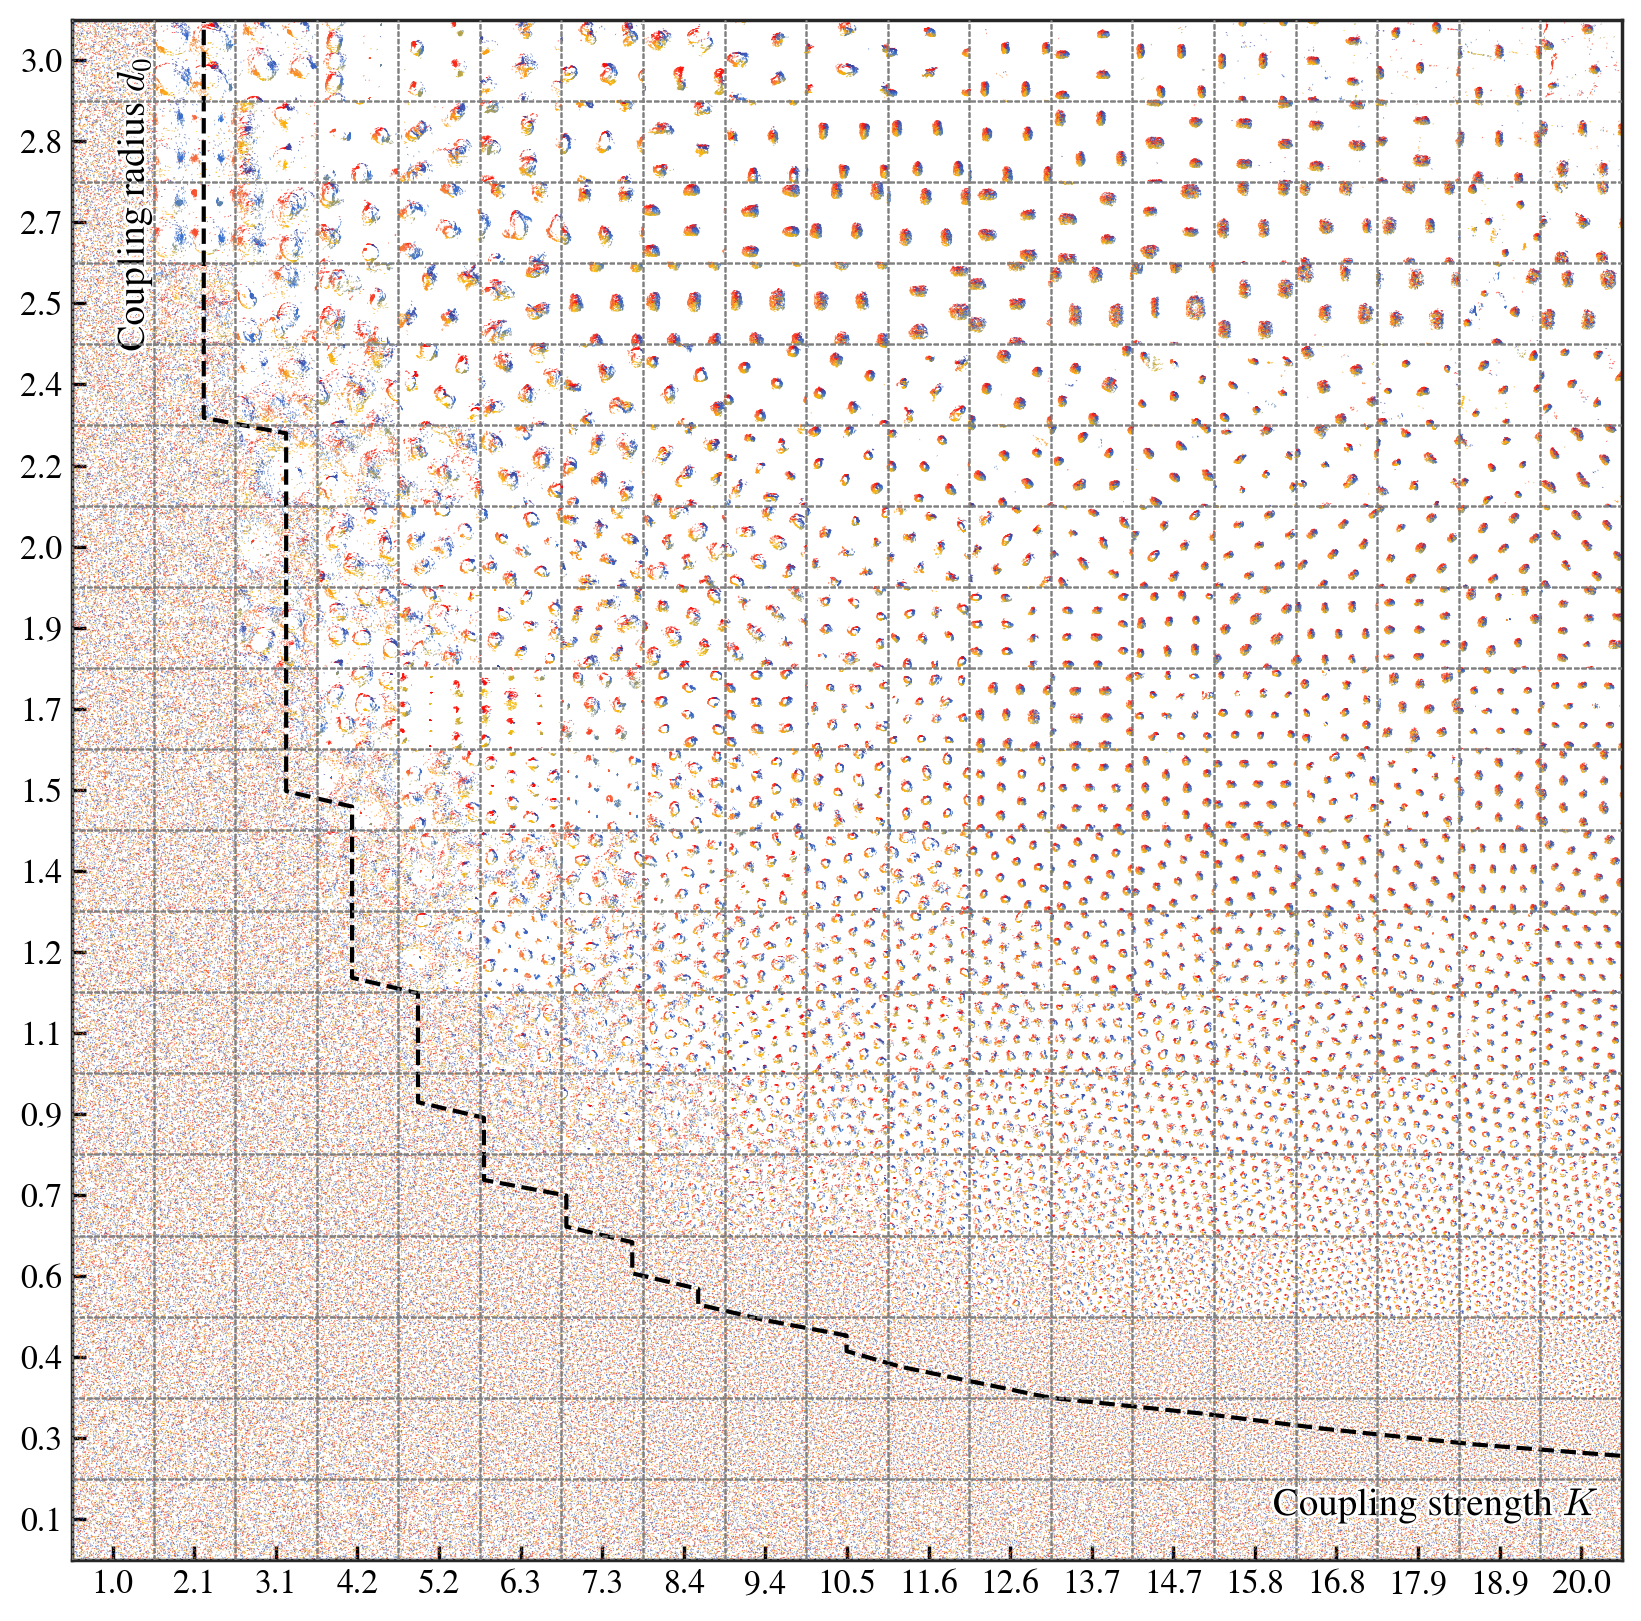

In [49]:
from matplotlib.patheffects import withStroke

with open("criticalThres.pkl", "rb") as f:
    criticalKs, criticalD0s = pickle.load(f)

colParams = distanceD0s
rowParams = strengthKs
colorsBy = "phase"

# fig, ax = plt.subplots(figsize=(len(rowParams) * 4, len(colParams) * 4))
fig, ax = plt.subplots(figsize=(10, 10))

for i, sa in enumerate(sas):
    if sa is None:
        continue
    row = i // len(rowParams)
    col = i % len(rowParams)
    
    positionShift = np.array([row, col]) * sa.model.boundaryLength
    positionX, phaseTheta = sa.get_state(-1)
    positionX = positionX + positionShift
    if colorsBy == "freq":
        colors = (
            ["red"] * (sa.model.freqOmega >= 0).sum() + 
            ["#414CC7"] * (sa.model.freqOmega < 0).sum()
        )
    elif colorsBy == "phase":
        colors = [cmap(i) for i in
            np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)
        ]

    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta), np.sin(phaseTheta), 
        color=colors,
        # scale=300, width=0.0004 / len(rowParams) * 7
        scale_units='inches', scale=100.0, width=0.002 / (len(rowParams) * 5) * 10
    )
    ax.axhline(
        y=col * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )
    ax.axvline(
        x=row * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )

boundaryLength = models[0].boundaryLength
plt.xlim(0, len(rowParams) * boundaryLength)
plt.ylim(0, len(colParams) * boundaryLength)
plt.xticks(
    np.arange(0, len(rowParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{k:.1f}" for k in rowParams]
)
plt.yticks(
    np.arange(0, len(colParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{d:.1f}" for d in colParams]
)

text1 = plt.text(len(rowParams) * boundaryLength * 0.88, len(rowParams) * boundaryLength * 0.035,
                 "Coupling strength $K$", # weight="bold",
                 fontsize=14, ha="center", va="center")
text2 = plt.text(len(rowParams) * boundaryLength * 0.04, len(rowParams) * boundaryLength * 0.88,
                 "Coupling radius $d_0$", # weight="bold",
                 fontsize=14, ha="center", va="center", rotation=90)
for text in [text1, text2]:
    text.set_path_effects([withStroke(linewidth=2, foreground='white')])
plt.tick_params(length=5, direction="in")

counts = len(strengthKs)
plt.plot(criticalKs / (strengthKs.max() - strengthKs.min()) * counts * sa.model.boundaryLength,
            criticalD0s / (distanceD0s.max() - distanceD0s.min()) * counts * sa.model.boundaryLength,
            lw=1.5, color="black", linestyle="--")

plt.savefig(
    f"figs/{sa.model.__class__.__name__}_"
    f"varying_strengthK_and_distanceD0_{colorsBy}_"
    f"a{phaseLags[0]:.2f}_Do{deltaOmegas[0]}"
    f"{'initPhaseTheta,' if sa.model.initPhaseTheta is not None else ''}"
    f"_aN{sa.model.agentsNum}_dist{sa.model.freqDist}.png", 
    bbox_inches="tight", dpi=300
)

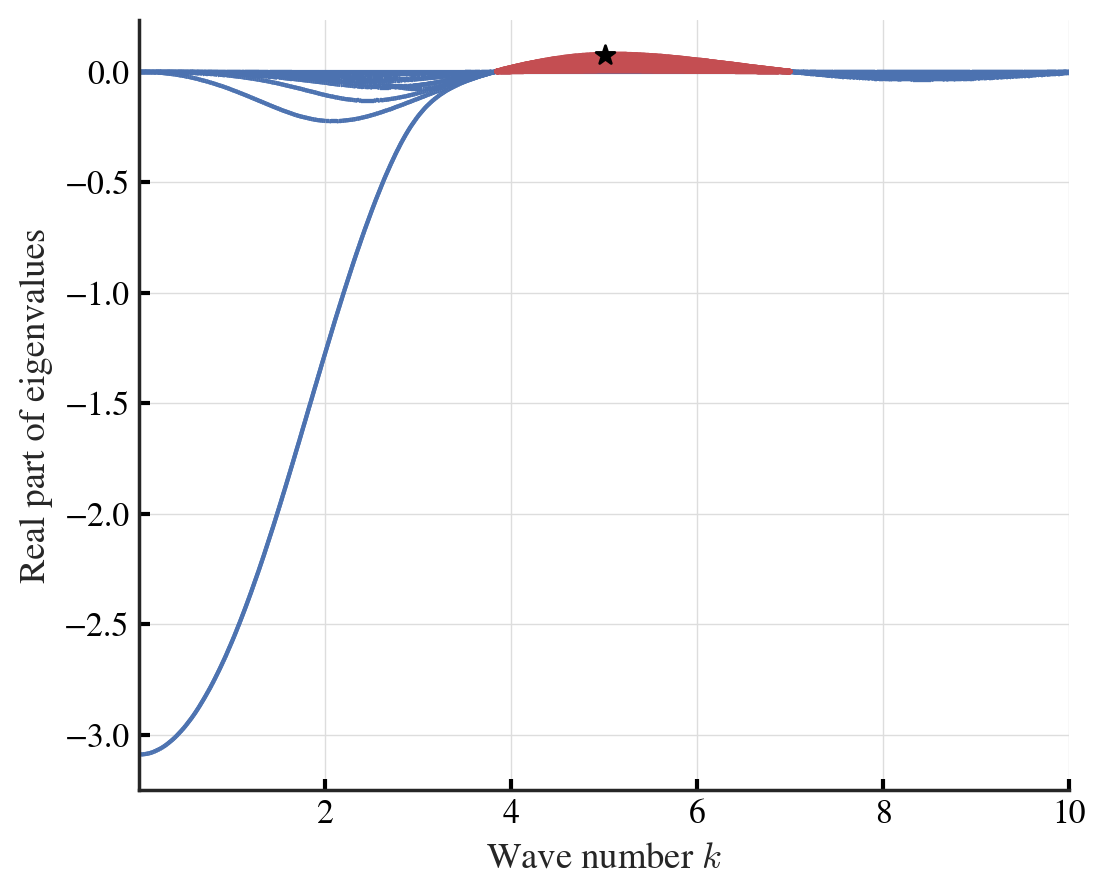

In [16]:
import numpy as np
from scipy.special import j1
from scipy.linalg import eig
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.collections import LineCollection

def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L0 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        if m == 1 or m == -1:
            L0[i,i] = besselTerm * np.exp(-m * alpha * 1j)
    
    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line
    
    H = L0 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    return eigenvalues[np.argsort(eigenvalues.real)].round(3)

def plot_continuous_spectrum(kValues: np.ndarray, params: dict, M: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)
    
    # create segments set for eval curves
    segments = []
    for i in range(allEvals.shape[1]):
        points = np.array([kValues, allEvals[:,i].real]).T.reshape(-1,1,2)
        # points.shape == (len(kValues), 1, 2), (1, 2) ~  a point in k-eval Fig
        segments.append(np.concatenate([points[:-1], points[1:]], axis=1))
        # segments.shape == (len(kValues), 2, 2)
        # (2, 2) ~ 2 adjacent points in k-eval Fig
    
    segments = np.concatenate(segments, axis=0)
    
    # plt.figure(figsize=(12, 8))

    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(-0.1, 0.1))
    plt.gca().add_collection(lc)

    plt.xlim(kValues.min(), kValues.max())
    # plt.ylim(-0.04, 0.01)
    plt.xlabel(r'Wave number $k$')
    plt.ylabel('Real part of eigenvalues')
    # plt.title('Continuous Eigenvalue Spectrum')
    plt.grid(True)
    
    firstPosK = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        plt.plot(kValues[positiveIdx], realEvals[positiveIdx], 'r-', lw=2)
        if len(positiveIdx) > 0:
            firstPosK.append(kValues[positiveIdx[0]])
    
    peakK = kValues[np.argmax(allEvals.real.max(axis=1))]
    plt.scatter(peakK, allEvals.real.max(), color='black', 
                s=50, label='Peak K', zorder=5, marker='*')

    # plt.show()

    firstPosK = np.min(firstPosK) if len(firstPosK) > 0 else 0
    
    
    return allEvals, firstPosK

def calc_first_break_K(kValues: np.ndarray, params: dict, M: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)
    
    # create segments set for eval curves
    segments = []
    for i in range(allEvals.shape[1]):
        points = np.array([kValues, allEvals[:,i].real]).T.reshape(-1,1,2)
        # points.shape == (len(kValues), 1, 2), (1, 2) ~  a point in k-eval Fig
        segments.append(np.concatenate([points[:-1], points[1:]], axis=1))
        # segments.shape == (len(kValues), 2, 2)
        # (2, 2) ~ 2 adjacent points in k-eval Fig
    
    segments = np.concatenate(segments, axis=0)
    
    firstPosK = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        if len(positiveIdx) > 0:
            firstPosK.append(kValues[positiveIdx[0]])

    firstPosK = np.min(firstPosK) if len(firstPosK) > 0 else 0
    
    return firstPosK

params = {
    'v': 3,       # speed
    'K': 20,   # coupling strength
    'd0': 1,    # coupling radius
    'alpha': 0.6 * np.pi      # phase frustration
}

kValues = np.linspace(0.0001, 10, 500)

allEvals, firstPosK = plot_continuous_spectrum(kValues, params, M=10)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(length=4, direction="in", color="black", width=1.5)
# plt.savefig("figs/continuous_spectrum.pdf", bbox_inches="tight")

In [43]:
import numpy as np
from scipy.special import j1
from scipy.linalg import eig
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.collections import LineCollection

def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10, decimals: int = 3):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L0 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        if m == 1 or m == -1:
            L0[i,i] = besselTerm * np.exp(-m * alpha * 1j)
    
    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line
    
    H = L0 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    return eigenvalues[np.argsort(eigenvalues.real)].round(decimals=decimals)

def plot_continuous_spectrum(kValues: np.ndarray, params: dict, M: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)

    for i in range(allEvals.shape[1]):
        plt.scatter(kValues, allEvals[:,i].real, c='b', s=5)

    plt.xlim(kValues.min(), kValues.max())
    # plt.ylim(-0.04, 0.01)
    plt.xlabel(r'Wave number $k$')
    plt.ylabel('Real part of eigenvalues')
    # plt.title('Continuous Eigenvalue Spectrum')
    plt.grid(True)
    
    firstPosK = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        plt.scatter(kValues[positiveIdx], realEvals[positiveIdx], c='r', s=5)
        if len(positiveIdx) > 0:
            firstPosK.append(kValues[positiveIdx[0]])
    
    # peakK = kValues[np.argmax(allEvals.real.max(axis=1))]
    firstPosK = np.min(firstPosK) if len(firstPosK) > 0 else 0
    plt.scatter(firstPosK, 0, color='black', 
                s=50, label='Peak K', zorder=5, marker='*')

    # plt.show()
    
    return allEvals, firstPosK

def calc_first_break_K(kValues: np.ndarray, params: dict, M: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)
    
    # create segments set for eval curves
    segments = []
    for i in range(allEvals.shape[1]):
        points = np.array([kValues, allEvals[:,i].real]).T.reshape(-1,1,2)
        # points.shape == (len(kValues), 1, 2), (1, 2) ~  a point in k-eval Fig
        segments.append(np.concatenate([points[:-1], points[1:]], axis=1))
        # segments.shape == (len(kValues), 2, 2)
        # (2, 2) ~ 2 adjacent points in k-eval Fig
    
    segments = np.concatenate(segments, axis=0)
    
    firstPosK = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        if len(positiveIdx) > 0:
            firstPosK.append(kValues[positiveIdx[0]])

    firstPosK = np.min(firstPosK) if len(firstPosK) > 0 else 0
    
    return firstPosK

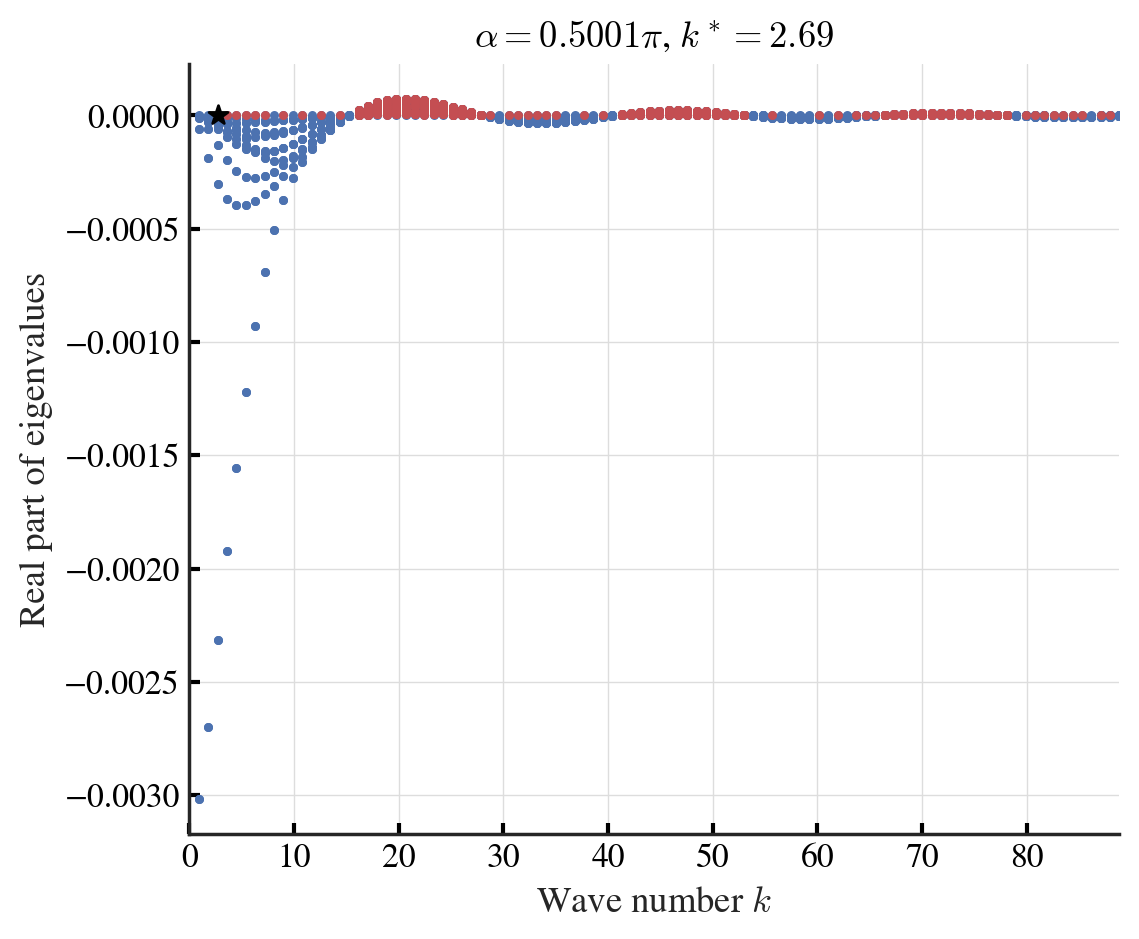

In [46]:
# alphas = np.arange(0.5, 1.1, 0.01) * np.pi
# alphas = np.linspace(0.5, 0.51, 20) * np.pi
# for alpha in alphas:
# Ks = np.linspace(0.1, 20, 10)
# for K in Ks:
d0s = [0.2]  # np.linspace(0.1, 3, 20)
alpha = (0.5 + 0.0001) * np.pi
for d0 in d0s:
    params = {
        'v': 3, 
        'K': 20, 
        'd0': 0.25,
        'alpha': alpha
    }

    # kValues = np.linspace(0.0001, 10, 500)
    boundaryLength = 7
    kValues = np.arange(1, 100) * 2 * np.pi / boundaryLength

    allEvals, firstPosK = plot_continuous_spectrum(kValues, params, M=10)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tick_params(length=4, direction="in", color="black", width=1.5)
    # plt.savefig("figs/continuous_spectrum.pdf", bbox_inches="tight")
    plt.title(r'$\alpha={:.4f}\pi$, $k^*={:.2f}$'.format(alpha/np.pi, firstPosK))
    plt.xlim(0, kValues.max())
    # plt.show()

# plt.savefig("figs/continuous_spectrum.pdf", bbox_inches="tight")

In [3]:
from scipy.linalg import eig
from scipy.special import j1


def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L0 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        if m == 1 or m == -1:
            L0[i,i] = besselTerm * np.exp(-m * alpha * 1j)
    
    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line
    
    H = L0 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    eigenvalues = eigenvalues[np.argsort(eigenvalues.real)]

    return eigenvalues

def calc_break_K(kValues: np.ndarray, params: dict, M: int = 10, decimals: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)
    rawEvals = allEvals.copy()
    if decimals is not None:
        allEvals = allEvals.round(decimals=decimals)

    posK = []
    posEvals = []
    posRawEvals = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        rawRealEvals = rawEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        if len(positiveIdx) > 0:
            posK.append(kValues[positiveIdx[0]])
            posEvals.append(realEvals[positiveIdx[0]])
            posRawEvals.append(rawRealEvals[positiveIdx[0]])

    # if params["alpha"] > np.pi / 2:
    #     print(params)
    #     # print(allEvals.real)
    #     for i in range(allEvals.shape[1]):
    #         plt.scatter(kValues, allEvals[:,i].real, c='b', s=5)
    #     plt.xlim(kValues.min(), kValues.max())
    #     plt.xlabel(r'Wave number $k$')
    #     plt.ylabel('Real part of eigenvalues')
    #     plt.grid(True)
    #     plt.gca().spines['top'].set_visible(False)
    #     plt.gca().spines['right'].set_visible(False)
    #     plt.tick_params(length=4, direction="in", color="black", width=1.5)
    #     plt.title(r'$\alpha={:.4f}\pi$, $k^*={:.2f}$'.format(alpha/np.pi, firstPosK))
    #     plt.xlim(0, kValues.max())

    #     # mark the positive evals
    #     for i in range(allEvals.shape[1]):
    #         realEvals = allEvals[:,i].real
    #         positiveIdx = np.where(realEvals > 0)[0]
    #         print(positiveIdx)
    #         plt.scatter(kValues[positiveIdx], realEvals[positiveIdx], c='r', s=5)

    #     plt.show()
    #     assert 0

    return np.array(posK), np.array(posEvals), np.array(posRawEvals)

def get_first_break_k(params: Dict[str, float], strict: bool = True, decimals: int = 10):
    # alphaPluss = np.arange(0, 0.03, 0.0001)
    alphaPluss = np.arange(0, 0.01, 0.0001)
    firstBreakK = None
    for alphaPlus in alphaPluss:
        params["alpha"] = (0.5 + alphaPlus) * np.pi

        kValues = np.arange(1, 100) * 2 * np.pi / params["boundaryLength"]
        # kValues = np.linspace(0.1, 100, 500)

        posK, posEvals, posRawEvals = calc_break_K(kValues, params, M=10, decimals=decimals)
        if len(posK) == 1:
            firstBreakK = posK[0]
            break
        if len(posK) > 1:
            if strict:
                assert False, "More than one positive k* found"
            else:
                if sum(posRawEvals == np.max(posRawEvals)) > 1:
                    assert False, "Multiple maxima found"
                firstBreakK = posK[np.argmax(posRawEvals)]
                break

    if firstBreakK is None:
        assert False, "No positive k* found"

    return firstBreakK

In [5]:
# product(Ks, d0s)
# params = (
#     list(product(np.linspace(10, 20, 50), np.linspace(0.1, 3, 50))) + 
#     list(product(np.linspace(0.1, 10, 50), np.linspace(0.1, 3, 50)))
# )
firstBreakKs = dict()
params = list(product(
    np.unique(np.concatenate([np.linspace(0.1, 10, 50), np.linspace(10, 25, 50)])),
    np.linspace(0.1, 3, 100)
))
for K, d0 in tqdm(params):
    params = {
        "v": 3,
        "K": K,
        "d0": d0,
        "boundaryLength": 7
    }
    firstBreakK = get_first_break_k(params, strict=False, decimals=6)
    firstBreakKs[(K, d0)] = firstBreakK
    # firstBreakKs[(K, d0)] = oldfirstBreakKs[(K, d0)]

  0%|          | 0/9900 [00:00<?, ?it/s]

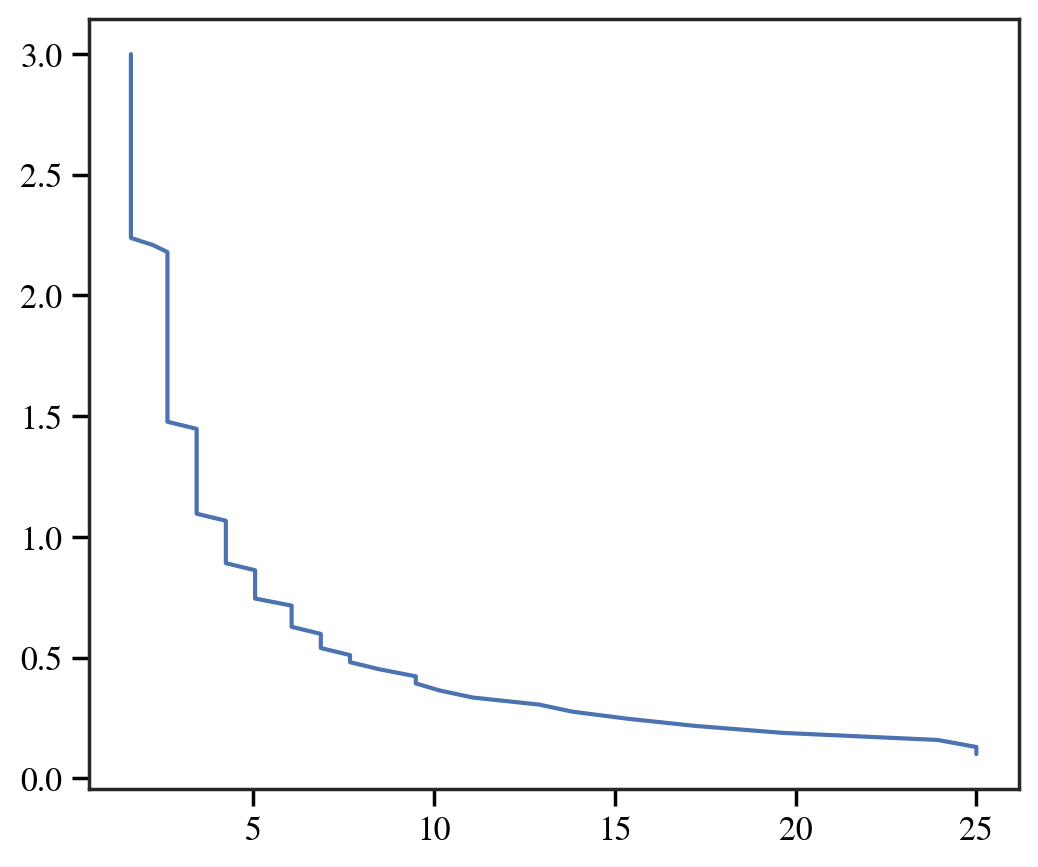

In [6]:
kDf = pd.Series(firstBreakKs).reset_index()
kDf.columns = ['K', 'd0', 'firstBreakK']
kDf = kDf.pivot(index='K', columns='d0', values='firstBreakK').sort_index(axis=0).sort_index(axis=1)
twoPiDivK = 2 * np.pi / kDf

speedV = 3
cellHalf = speedV / np.abs(kDf.index.values * np.sin(0.5 * np.pi)) * 2

criticalKs = list()
criticalD0s = kDf.columns.values
for d0 in criticalD0s:
    subTwoPiDivK = twoPiDivK[d0]
    if (subTwoPiDivK < cellHalf).all():
        criticalKs.append(kDf.index[-1])
        continue
    criticalK1 = subTwoPiDivK[subTwoPiDivK > cellHalf].index[0]
    criticalK2 = subTwoPiDivK[subTwoPiDivK < cellHalf].index[-1]
    criticalKs.append((criticalK1 + criticalK2) / 2)

plt.plot(criticalKs, criticalD0s)

In [7]:
import pickle

with open("criticalThres.pkl", "wb") as f:
    pickle.dump((criticalKs, criticalD0s), f)

In [127]:
twoPiDivK

d0             0.10      0.15      0.20      0.25      0.30      0.35  \
K                                                                       
1.000000   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
2.055556   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
3.111111   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
4.166667   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
5.222222   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
6.277778   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
7.333333   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
8.388889   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
9.444444   0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
10.500000  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
11.555556  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
12.611111  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
13.666667  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
14.722222  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
15.777778  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
16.833333  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
17.888889  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
18.944444  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   
20.000000  0.162791  0.241379  0.318182  0.388889  0.466667  0.538462   

d0             0.40  0.45      0.50   0.55   0.60  0.65  0.70      0.75  \
K                                                                         
1.000000   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
2.055556   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
3.111111   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
4.166667   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
5.222222   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
6.277778   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
7.333333   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
8.388889   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
9.444444   0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
10.500000  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
11.555556  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
12.611111  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
13.666667  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
14.722222  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
15.777778  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
16.833333  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
17.888889  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
18.944444  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   
20.000000  0.636364   0.7  0.777778  0.875  0.875   1.0   1.0  1.166667   

d0             0.80      0.85  0.90  0.95  1.00  
K                                                
1.000000   1.166667  1.166667   1.4   1.4   1.4  
2.055556   1.166667  1.166667   1.4   1.4   1.4  
3.111111   1.166667  1.166667   1.4   1.4   1.4  
4.166667   1.166667  1.166667   1.4   1.4   1.4  
5.222222   1.166667  1.166667   1.4   1.4   1.4  
6.277778   1.166667  1.166667   1.4   1.4   1.4  
7.333333   1.166667  1.166667   1.4   1.4   1.4  
8.388889   1.166667  1.166667   1.4   1.4   1.4  
9.444444   1.166667  1.166667   1.4   1.4   1.4  
10.500000  1.166667  1.166667   1.4   1.4   1.4  
11.555556  1.166667  1.166667   1.4   1.4   1.4  
12.611111  1.166667  1.166667   1.4   1.4   1.4  
13.666667  1.166667  1.166667   1.4   1.4   1.4  
14.722222  1.166667  1.166667   1.4   1.4   1.4  
15.777778  1.166667  1.166667   1.4   1.4   1.4  
16.833333  1.166667  1.166667   1.4   1.

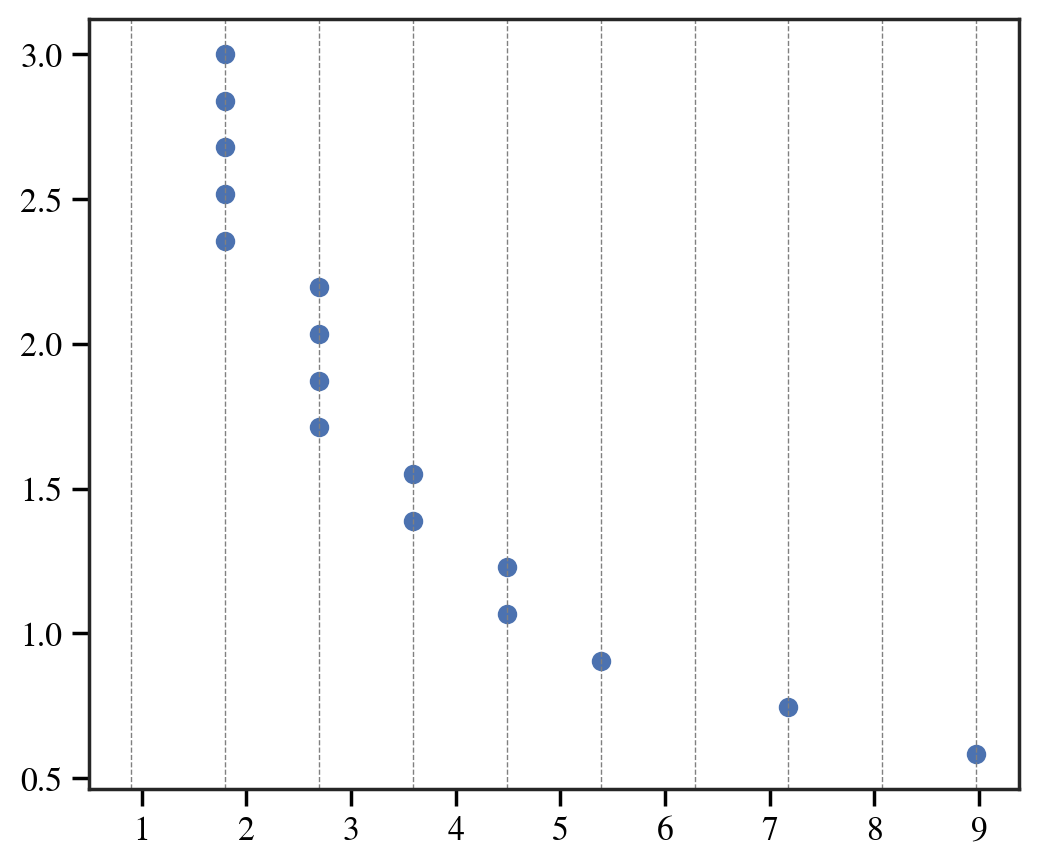

In [119]:
critical = kDf.iloc[-1]
plt.scatter(critical.values, critical.index)
boundaryLength = 7
kValues = np.arange(1, 11) * 2 * np.pi / boundaryLength
for k in kValues:
    plt.axvline(k, color='gray', linestyle='--', linewidth=0.5)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm

params = {
    'v': 3, 
    'K': 20, 
    'd0': 1.55,
}

evalsForAlpha = dict()

boundaryLength = 7
alphaPluss = np.arange(0, 0.5, 0.001)
kValues = np.arange(1, 21) * 2 * np.pi / boundaryLength

for alphaPlus in tqdm(alphaPluss):
    alpha = (0.5 + alphaPlus) * np.pi
    params["alpha"] = alpha

    boundaryLength = 7

    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M=10, decimals=5)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)
    evalsForAlpha[alpha] = allEvals

colors = ["#FFC001", "#F46F43", "#FF0000"]
posCmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)

all_stdAlpha = []
all_kValues = []
all_maxRes = []

for alpha, allEvals in evalsForAlpha.items():
    stdAlpha = alpha / np.pi
    maxRes = allEvals.real.max(axis=1)
    
    all_stdAlpha.extend(np.ones_like(maxRes) * stdAlpha)
    all_kValues.extend(kValues)
    all_maxRes.extend(maxRes)

all_stdAlpha = np.array(all_stdAlpha)
all_kValues = np.array(all_kValues)
all_maxRes = np.array(all_maxRes)


evalsForAlpha = dict()

alphaPluss = np.arange(0, 0.002, 0.00001)
kValues = np.arange(1, 21) * 2 * np.pi / boundaryLength

for alphaPlus in tqdm(alphaPluss):
    alpha = 0.5 * np.pi + alphaPlus
    params["alpha"] = alpha

    boundaryLength = 7

    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M=10, decimals=5)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)
    evalsForAlpha[alpha] = allEvals

colors = ["#FFC001", "#F46F43", "#FF0000"]
posCmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)

sub_all_stdAlpha = []
sub_all_kValues = []
sub_all_maxRes = []

for alpha, allEvals in evalsForAlpha.items():
    stdAlpha = alpha / np.pi
    maxRes = allEvals.real.max(axis=1)
    
    sub_all_stdAlpha.extend(np.ones_like(maxRes) * stdAlpha)
    sub_all_kValues.extend(kValues)
    sub_all_maxRes.extend(maxRes)

sub_all_stdAlpha = np.array(sub_all_stdAlpha)
sub_all_kValues = np.array(sub_all_kValues)
sub_all_maxRes = np.array(sub_all_maxRes)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 214.57it/s]


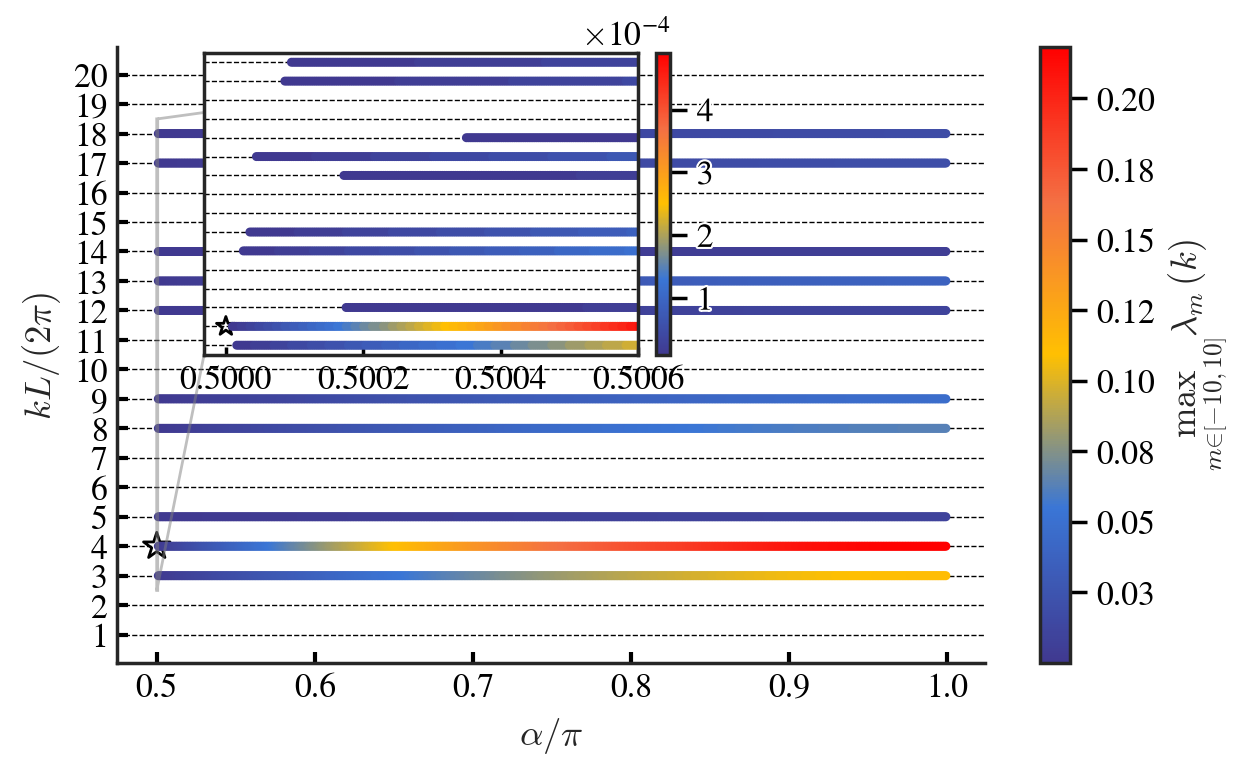

In [5]:
import matplotlib.patheffects as path_effects
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(7, 4))
mask_neg = all_maxRes <= 0
for i in range(1, len(kValues) + 1):
    ax.axhline(y=i, color='black', linestyle='--', linewidth=0.5, zorder=0)
ax.scatter(0.5, 4, marker='*', s=100, facecolors='none', edgecolors='black', zorder=0)

sc = ax.scatter(all_stdAlpha[~mask_neg], all_kValues[~mask_neg] / (2 * np.pi / boundaryLength), 
                 s=5, c=all_maxRes[~mask_neg], cmap=cmap)

cbar = fig.colorbar(sc, label=r'$\max_{m\in \left[ -10,10 \right]} \lambda _m(k)$')

cbar.formatter = ticker.FuncFormatter(lambda x, _: f"{x:.2f}")
cbar.update_ticks()

plt.ticklabel_format(axis='x', style='sci')

plt.xlabel(r'$\alpha / \pi$')
plt.ylabel(r"$kL / (2\pi)$")
plt.yticks(np.arange(1, len(kValues) + 1))
plt.tick_params(direction='in', length=4, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

axTide = ax.inset_axes([0.1, 0.5, 0.5, 0.49])

for i in range(1, len(kValues) + 1):
    axTide.axhline(y=i, color='black', linestyle='--', linewidth=0.5, zorder=0)
axTide.scatter(0.5, 4, marker='*', s=50, facecolors='none', edgecolors='black', zorder=0)

sub_mask_neg = sub_all_maxRes <= 0
sc = axTide.scatter(sub_all_stdAlpha[~sub_mask_neg], 
                    sub_all_kValues[~sub_mask_neg] / (2 * np.pi / boundaryLength), 
                 s=5, c=sub_all_maxRes[~sub_mask_neg], cmap=cmap)
cax = fig.add_axes([0.51, 0.495, 0.01, 0.377])  # [left, bottom, width, height]
tideCbar = fig.colorbar(sc, cax=cax, ticks=[0.0001, 0.0002, 0.0003, 0.0004])
tideCbar.formatter = ticker.ScalarFormatter(useMathText=True) 
tideCbar.formatter.set_powerlimits((-3, 4))
for label in tideCbar.ax.get_yticklabels():
    label.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='white'),  # 白色描边（宽度2）
        path_effects.Normal()  # 正常显示文本
    ])

axTide.set_xlim(None, 0.5006)
axTide.set_ylim(2.5, 18.5)
axTide.set_yticks([])
axTide.tick_params(length=3, direction="in")

ax.indicate_inset_zoom(axTide, linewidth=1)

plt.show()

In [52]:
ax.indicate_inset?

Signature:
ax.indicate_inset(
    bounds,
    inset_ax=None,
    *,
    transform=None,
    facecolor='none',
    edgecolor='0.5',
    alpha=0.5,
    zorder=4.99,
    **kwargs,
)
Docstring:
Add an inset indicator to the Axes.  This is a rectangle on the plot
at the position indicated by *bounds* that optionally has lines that
connect the rectangle to an inset Axes (`.Axes.inset_axes`).

Warnings
--------
This method is experimental as of 3.0, and the API may change.

Parameters
----------
bounds : [x0, y0, width, height]
    Lower-left corner of rectangle to be marked, and its width
    and height.

inset_ax : `.Axes`
    An optional inset Axes to draw connecting lines to.  Two lines are
    drawn connecting the indicator box to the inset Axes on corners
    chosen so as to not overlap with the indicator box.

transform : `.Transform`
    Transform for the rectangle coordinates. Defaults to
    `ax.transAxes`, i.e. the units of *rect* are in Axes-relative
    coordinates.

facecolor : 

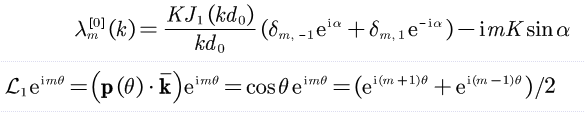

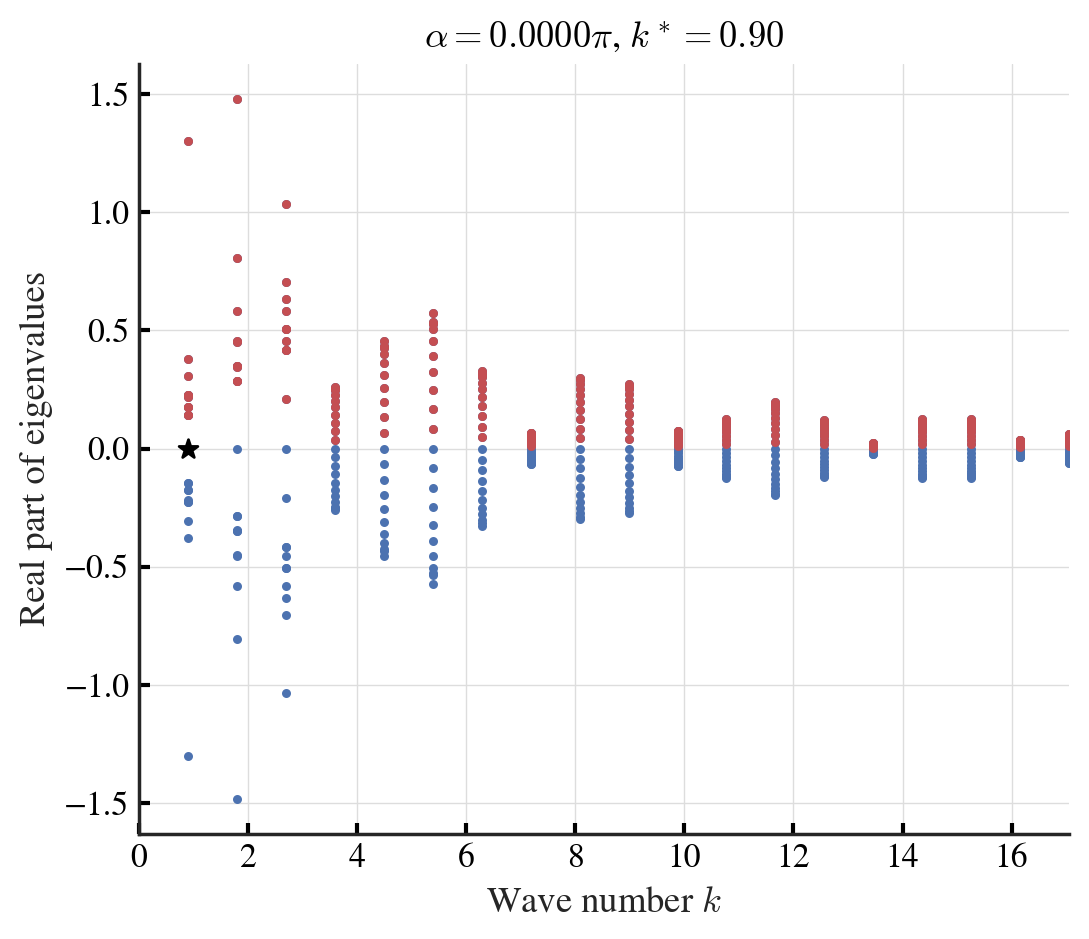

In [15]:
import numpy as np
from scipy.special import j1
from scipy.linalg import eig
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.collections import LineCollection

def compute_eigenvalues_for_k(k: float, params: dict, M: int = 10, decimals: int = 3):
    """
    params: dict:
        - v: speedV
        - K: coupling strength
        - d0: coupling radius
        - alpha: phase frustration
    M: truncated basis size (m from -M to M)
    """
    v = params['v']
    K = params['K']
    d0 = params['d0']
    alpha = params['alpha']
    
    m_values = np.arange(-M, M+1)
    dim = len(m_values)
    
    L2 = np.zeros((dim, dim), dtype=complex)
    besselTerm = K * j1(k*d0) / (k*d0)
    for i, m in enumerate(m_values):
        L2[i, i] = besselTerm * (-m * np.sin(alpha))
    
        if i > 0:
            L2[i, i-1] = besselTerm * (m / 2 * np.exp(-1j * alpha))
        
        if i < dim - 1:
            L2[i, i+1] = besselTerm * (-m / 2 * np.exp(1j * alpha))

    L1 = np.zeros((dim, dim), dtype=complex)
    for i in range(1, dim):
        L1[i-1, i] = 0.5  # upper line
        L1[i, i-1] = 0.5  # lower line

    H = L2 - 1j * v * k * L1
    eigenvalues = eig(H)[0]
    
    # sort with Real part
    return eigenvalues[np.argsort(eigenvalues.real)].round(decimals=decimals)

def plot_continuous_spectrum(kValues: np.ndarray, params: dict, M: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)

    for i in range(allEvals.shape[1]):
        plt.scatter(kValues, allEvals[:,i].real, c='b', s=5)

    plt.xlim(kValues.min(), kValues.max())
    # plt.ylim(-0.04, 0.01)
    plt.xlabel(r'Wave number $k$')
    plt.ylabel('Real part of eigenvalues')
    # plt.title('Continuous Eigenvalue Spectrum')
    plt.grid(True)
    
    firstPosK = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        plt.scatter(kValues[positiveIdx], realEvals[positiveIdx], c='r', s=5)
        if len(positiveIdx) > 0:
            firstPosK.append(kValues[positiveIdx[0]])
    
    # peakK = kValues[np.argmax(allEvals.real.max(axis=1))]
    firstPosK = np.min(firstPosK) if len(firstPosK) > 0 else 0
    plt.scatter(firstPosK, 0, color='black', 
                s=50, label='Peak K', zorder=5, marker='*')

    # plt.show()
    
    return allEvals, firstPosK

def calc_first_break_K(kValues: np.ndarray, params: dict, M: int = 10):
    allEvals = []
    for k in kValues:
        evals = compute_eigenvalues_for_k(k, params, M)
        allEvals.append(evals)
    
    allEvals = np.array(allEvals)  # allEvals.shape == (len(kValues), 2M+1)
    
    # create segments set for eval curves
    segments = []
    for i in range(allEvals.shape[1]):
        points = np.array([kValues, allEvals[:,i].real]).T.reshape(-1,1,2)
        # points.shape == (len(kValues), 1, 2), (1, 2) ~  a point in k-eval Fig
        segments.append(np.concatenate([points[:-1], points[1:]], axis=1))
        # segments.shape == (len(kValues), 2, 2)
        # (2, 2) ~ 2 adjacent points in k-eval Fig
    
    segments = np.concatenate(segments, axis=0)
    
    firstPosK = []

    # mark the positive evals
    for i in range(allEvals.shape[1]):
        realEvals = allEvals[:,i].real
        positiveIdx = np.where(realEvals > 0)[0]
        if len(positiveIdx) > 0:
            firstPosK.append(kValues[positiveIdx[0]])

    firstPosK = np.min(firstPosK) if len(firstPosK) > 0 else 0
    
    return firstPosK

# alphas = np.arange(0.5, 1.1, 0.01) * np.pi
# alphas = np.linspace(0.5, 0.51, 20) * np.pi
# for alpha in alphas:
# Ks = np.linspace(0.1, 20, 10)
# for K in Ks:
d0s = [1]  # np.linspace(0.1, 3, 20)
alpha = (0. + 0.000) * np.pi
for d0 in d0s:
    params = {
        'v': 3, 
        'K': 20, 
        'd0': d0,
        'alpha': alpha
    }

    # kValues = np.linspace(0.0001, 10, 500)
    boundaryLength = 7
    kValues = np.arange(1, 20) * 2 * np.pi / boundaryLength

    allEvals, firstPosK = plot_continuous_spectrum(kValues, params, M=10)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tick_params(length=4, direction="in", color="black", width=1.5)
    # plt.savefig("figs/continuous_spectrum.pdf", bbox_inches="tight")
    plt.title(r'$\alpha={:.4f}\pi$, $k^*={:.2f}$'.format(alpha/np.pi, firstPosK))
    plt.xlim(0, kValues.max())
    # plt.show()

plt.savefig("figs/continuous_spectrum_uniform_sync.pdf", bbox_inches="tight")


In [1]:
import sympy as sp

M = 2
v, k, K, alpha, d0 = sp.symbols('v k K alpha d_0')
m_values = range(-M, M+1)
dim = len(m_values)

# Create symbolic matrices
L0 = sp.zeros(dim, dim)
besselTerm = K * sp.besselj(1, k*d0) / (k*d0)  # Assuming j1 is a Bessel function

for i, m in enumerate(m_values):
    if m == 1 or m == -1:
        L0[i,i] = besselTerm * sp.exp(-m * alpha * sp.I)
        # pass

L1 = sp.zeros(dim, dim)
for i in range(1, dim):
    L1[i-1, i] = sp.Rational(1, 2)  # upper diagonal
    L1[i, i-1] = sp.Rational(1, 2)  # lower diagonal

H = L0 - sp.I * v * k * L1

In [2]:
lambda_var = sp.symbols('lambda')
charpoly = H.charpoly(lambda_var).as_expr(lambda_var)
coeffs = [charpoly.coeff(lambda_var, i) for i in range(H.rows, -1, -1)]
for coeff in coeffs:
    print(sp.latex(coeff))

1
- \frac{2 K \cos{\left(\alpha \right)} J_{1}\left(d_{0} k\right)}{d_{0} k}
\frac{K^{2} J^{2}_{1}\left(d_{0} k\right)}{d_{0}^{2} k^{2}} + k^{2} v^{2}
- \frac{K k v^{2} \cos{\left(\alpha \right)} J_{1}\left(d_{0} k\right)}{d_{0}}
\frac{3 k^{4} v^{4}}{16}
0


In [5]:
a4 = coeffs[0]
a3 = coeffs[1]
a2 = coeffs[2]
a1 = coeffs[3]
a0 = coeffs[4]

In [16]:
b1 = ((a3 * a2 - a4 * a1) / a3).simplify()
display(b1)
print(sp.latex(b1))

K**2*besselj(1, d_0*k)**2/(d_0**2*k**2) + k**2*v**2/2

\frac{K^{2} J^{2}_{1}\left(d_{0} k\right)}{d_{0}^{2} k^{2}} + \frac{k^{2} v^{2}}{2}


In [17]:
b2 = ((a3 * a0 - a4 * 0) / a3).simplify()
display(b2)
print(sp.latex(b2))

3*k**4*v**4/16

\frac{3 k^{4} v^{4}}{16}


In [18]:
c1 = ((b1 * a1 - a3 * b2) / b1).simplify()
display(c1)
print(sp.latex(c1))

K*k*v**2*(-8*K**2*besselj(1, d_0*k)**2 - d_0**2*k**4*v**2)*cos(alpha)*besselj(1, d_0*k)/(4*d_0*(2*K**2*besselj(1, d_0*k)**2 + d_0**2*k**4*v**2))

\frac{K k v^{2} \left(- 8 K^{2} J^{2}_{1}\left(d_{0} k\right) - d_{0}^{2} k^{4} v^{2}\right) \cos{\left(\alpha \right)} J_{1}\left(d_{0} k\right)}{4 d_{0} \left(2 K^{2} J^{2}_{1}\left(d_{0} k\right) + d_{0}^{2} k^{4} v^{2}\right)}


In [19]:
d1 = ((c1 * b2 - b1 * 0) / c1).simplify()
display(d1)
print(sp.latex(d1))

3*k**4*v**4/16

\frac{3 k^{4} v^{4}}{16}
